# Plankton classification using Google Colab, TensorFlow, and Keras

* This is intended to follow on to SIOC 209 SP24 Lecture 7, which introduced Classification using Convolutional Neural Networks. It was presented in class on Wednesday, May 1 by Jeff Ellen (current best email: jsellen@ucsd.edu)

* This code is intentionally simple to be the starting point for a longer investigation. (see assignment rubric)

* In order for this code to execute most efficiently, in the upper right-hand corner, there is a pulldown menu near the 'RAM' and 'Disk' sparklines. Pull that down, select 'Change Runtime Type' to **'TPU v2'**.

* Without a paid Google Colab plan, this will limit your session to a few hours, and perhaps less during peak usage. But it does make the code run faster. So if you are editing figures, it may be advisable to switch runtimes back to CPU to conserve your allocation. *If you switch runtimes, you will need to re-execute notebook cells, and re-authenticate Google Drive*

# Confirm required libraries are availble within the environment

* This code should only take a few seconds, and will have no output

In [1]:
#Colab runtime ~10 sec CPU, ~10 sec on TPU
import os
import numpy as np
import keras
import glob
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

from keras import layers
from tensorflow import data as tf_data

#If no errors, then complete

In [2]:
!pip install pydot graphviz

#Load the data and split it between train and test sets

* This code is more complicated than when using a 'built in' dataset.

* This code contains a few hyperparameters. In non-tutorial code, these could be all near the top, passing in as part of a function definition, or be command line parameters so a shell script could manage multiple executions

* Instead of creating lists/dicts to keep track of images, **keras.utils.image_dataset_from_directory()** on a folder of labeled image folders creates a 'batched' dataset, and has common CNN data management tricks built in such as resizing the image, and converting the class names to one-hot encoded vectors

* The batching is not only used during training, but is like a python Generator in that it helps **efficiently use system resources by not forcing the entire dataset to be in memory.**

* Using 'built-in' functions like image resizing gets the fastest results, but may be non-optimal for your data. *For example, is it cropping the image or is it changing the aspect ratio?*


In [3]:
#Colab runtime ~30 sec
# set_15k = '/home/grader-sioc209-02/public/plankton_data/sioc_209_30k' # should be changed according to accountName
# set_15k = '/home/byk004/public/plankton_data/sioc_209_30k'
set_15k = './plankton_data/sioc_209_15k'

print(f'-Found {len(os.listdir(set_15k))} sub-directories to use for classification task')

#Specify some of the hyperparameters required by the image_dataset_from_directory helper function
image_size = (128, 128)
batch_size = 32
val_split = 0.3

#Assemble the train
train_ds = keras.utils.image_dataset_from_directory(
    set_15k,
    validation_split=val_split,
    subset="training",  #"Both" is also an option
    seed=40,    #using a fixed random seed should result in the exact same splits, which is useful when debugging/developing
    image_size=image_size,
    batch_size=batch_size,
    label_mode = 'categorical'
)

val_ds = keras.utils.image_dataset_from_directory(
    set_15k,
    validation_split=val_split,
    subset="validation",  #"Both" is also an option
    seed=40,    #using a fixed random seed should result in the exact same splits, which is useful when debugging/developing
    image_size=image_size,
    batch_size=batch_size,
    label_mode = 'categorical'
)

#split validation into true validation and hold-out (test) datasets
val_batches = tf_data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

#technique copied from https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker

-Found 30 sub-directories to use for classification task
Found 13178 files belonging to 30 classes.
Using 9225 files for training.


2024-05-09 21:53:14.385844: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-05-09 21:53:14.385875: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-09 21:53:14.385886: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-09 21:53:14.385932: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-09 21:53:14.385950: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 13178 files belonging to 30 classes.
Using 3953 files for validation.


#Prepare the data, Examine some images

* These plankton images are of various sizes, and they are recorded as 0-255 greyscale. Since the CNNs expect values [0,1], they should be normalized.

* Consider whether this normalization will be executed now, or when each image is loaded

2024-05-09 21:53:15.468439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


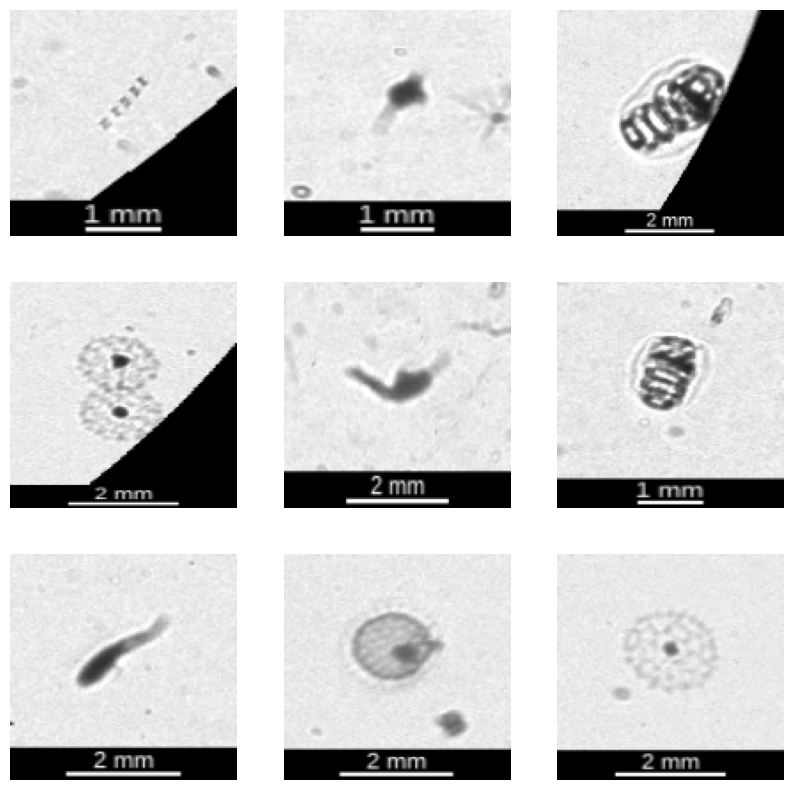

In [4]:
#Colab runtime ~1 min
train_ds_norm = train_ds.map(
    lambda x, y: (x / 255.0, y),
    num_parallel_calls=tf_data.AUTOTUNE
)
val_ds_norm = val_ds.map(
    lambda x, y: (x / 255.0, y),
    num_parallel_calls=tf_data.AUTOTUNE
)

train_ds_norm = train_ds_norm.prefetch(tf_data.AUTOTUNE)
val_ds_norm = val_ds_norm.prefetch(tf_data.AUTOTUNE)

#Examine some of the images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):   #this gets 1 batch of images (32 by default)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        # plt.title(int(labels[i]))
        plt.axis("off")

#Create/Select the models's shape

* Implemenation based on 5-layer architecture from lecture slides

* Ensure pooling is not called too many times given original image size

* Code provided by Byungjun Kim

* Number of layers is a hyperparaemter

* Fully Connected / Dense layer size(s) are a hyperparameter

* Different implmentation style: Compare to

> model = Sequential()
>
> model.add(layers.Conv2D()
>
> model.add(layers.MaxPooling2D())
>
> model.add(layers.Conv2D())
>
> ...


In [5]:
#colab runtime ~1 sec
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    print(inputs.shape)
    x = layers.Conv2D(16, 3, padding="same")(inputs)
    x = layers.MaxPooling2D(2, padding="same")(x)

    for size in [32, 64, 64]:
        # x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 3, padding="same")(x)
        # x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(2, padding="same")(x)
    x = layers.Flatten()(x)

    x = layers.Dense(512)(x)
    x = layers.Dense(512)(x)
    x = layers.Dense(27)(x)

    #For binary classification, a single output unit is required
    #Otherwise for 1-hot encodings, the number of classes should be used
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size+(3,), num_classes=30)
# keras.utils.plot_model(model, show_shapes=False) #This line doesn't work with TPUv2 environment :-/

(None, 128, 128, 3)


#Train the compiled model

* Callbacks execute between epochs, can be used to create logging, save checkpoints, etc.

* The built in function creates some stats while in progress

* **model.fit() returns a history object, likely want to capture it.** Not having any assignment (e.g. starting the line of code with model.fit() and no assignment, as in model.compile()

* *This history object will get erased if your jupyter/colab notebook runtime gets reset, may want to persist it separately

In [6]:
epochs = 25

#With more complicated models, it is possible to re-load the existing weights and resume training
#This is essentially the same as transfer learning.
callbacks = [
    keras.callbacks.ModelCheckpoint("./savedModels/save_at_{epoch}.keras"), #to be changed to your private directory
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
    metrics=['accuracy']
)

#Having compiled the model, start the training (aka fitting)
print('Done with model.compile, starting fitting...')
history = model.fit( #save the history
    train_ds_norm,  #use the normalized version
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds_norm, #use the normalized version
)

Done with model.compile, starting fitting...
Epoch 1/25


2024-05-09 21:53:16.532089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


289/289 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.1386 - loss: 3.2842 - val_accuracy: 0.2679 - val_loss: 2.6939
Epoch 2/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.3055 - loss: 2.6177 - val_accuracy: 0.3845 - val_loss: 2.3677
Epoch 3/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.4069 - loss: 2.3355 - val_accuracy: 0.4116 - val_loss: 2.2556
Epoch 4/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.4626 - loss: 2.1833 - val_accuracy: 0.4432 - val_loss: 2.2024
Epoch 5/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.5110 - loss: 2.0617 - val_accuracy: 0.4703 - val_loss: 2.1203
Epoch 6/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.5575 - loss: 1.9506 - val_accuracy: 0.4710 - val_loss: 2.1825
Epoch 7/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.5991 - loss: 1.8366 - val_accuracy: 0.4846 - val_loss: 2.1427
Epoch 8/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.6320 - loss: 1.7344 - val_accurac

# Or use a slightly smaller model

* This cell is being included because I haven't yet cleared the output, so I can show what should happen at the end of training

In [7]:
#colab runtime ~1 sec
def make_smaller_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    print(inputs.shape)
    x = layers.Conv2D(16, 3, padding="same")(inputs)
    x = layers.MaxPooling2D(2, padding="same")(x)

    for size in [32, 64]:
        # x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 3, padding="same")(x)
        # x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(2, padding="same")(x)
    x = layers.Flatten()(x)

    x = layers.Dense(64)(x)
    x = layers.Dense(32)(x)
    x = layers.Dense(27)(x)

    if num_classes == 2:
        units = 1
    else:
        units = num_classes
    # x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

smaller_model = make_smaller_model(input_shape=image_size+(3,), num_classes=30)
#keras.utils.plot_model(model, show_shapes=True)

epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("./savedModels/save_small_at_{epoch}.keras"), #to be changed to your private directory
]
smaller_model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
    metrics=['accuracy']
)
print('Done with smaller_model.compile, starting fitting...')
smaller_history = smaller_model.fit(
    train_ds_norm,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds_norm,
)

(None, 128, 128, 3)
Done with smaller_model.compile, starting fitting...
Epoch 1/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.1200 - loss: 3.3046 - val_accuracy: 0.2205 - val_loss: 2.8234
Epoch 2/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.2665 - loss: 2.7607 - val_accuracy: 0.3303 - val_loss: 2.6629
Epoch 3/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.3521 - loss: 2.5125 - val_accuracy: 0.3868 - val_loss: 2.4957
Epoch 4/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.4102 - loss: 2.3510 - val_accuracy: 0.3800 - val_loss: 2.4184
Epoch 5/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.4526 - loss: 2.2203 - val_accuracy: 0.3928 - val_loss: 2.3801
Epoch 6/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5030 - loss: 2.0917 - val_accuracy: 0.4214 - val_loss: 2.3134
Epoch 7/25
289/289 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.5497 - loss: 1.9816 - val_accuracy: 0.4153 - val_loss: 2.3484
Epoch 8/25
289/28

#Examine loss curve

* Look to see if desired amount of learning is complete

* Look for possible overfitting

Text(0.5, 1.0, 'Loss Curves')

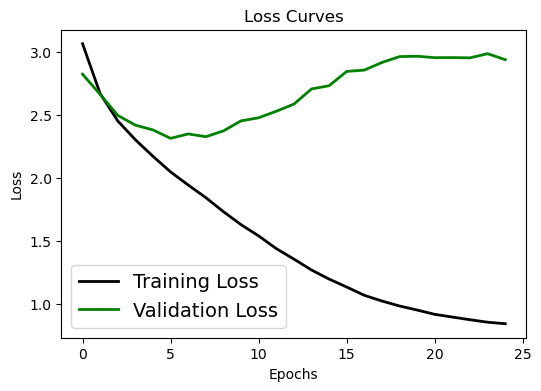

In [8]:
# Loss curve
plt.figure(figsize=[6,4])
plt.plot(smaller_history.history['loss'], 'black', linewidth=2.0)
plt.plot(smaller_history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
# plt.yscale('log')
plt.title('Loss Curves', fontsize=12)

#Accuracy Curve

* Loss is required to be computed every epoch, accuracy isn't

* Shows the same information

Text(0.5, 1.0, 'Accuracy Curves')

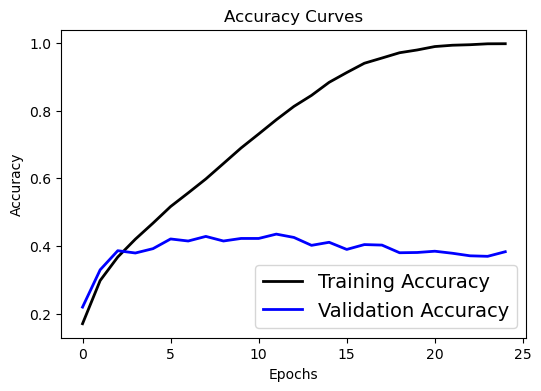

In [9]:
# Accuracy curve
plt.figure(figsize=[6,4])
plt.plot(smaller_history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(smaller_history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

#Examine individual predictions

* Check a few of the predictions

* Need to convert from integers back to strings

* Getting individual predictions requires collecting a batch

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


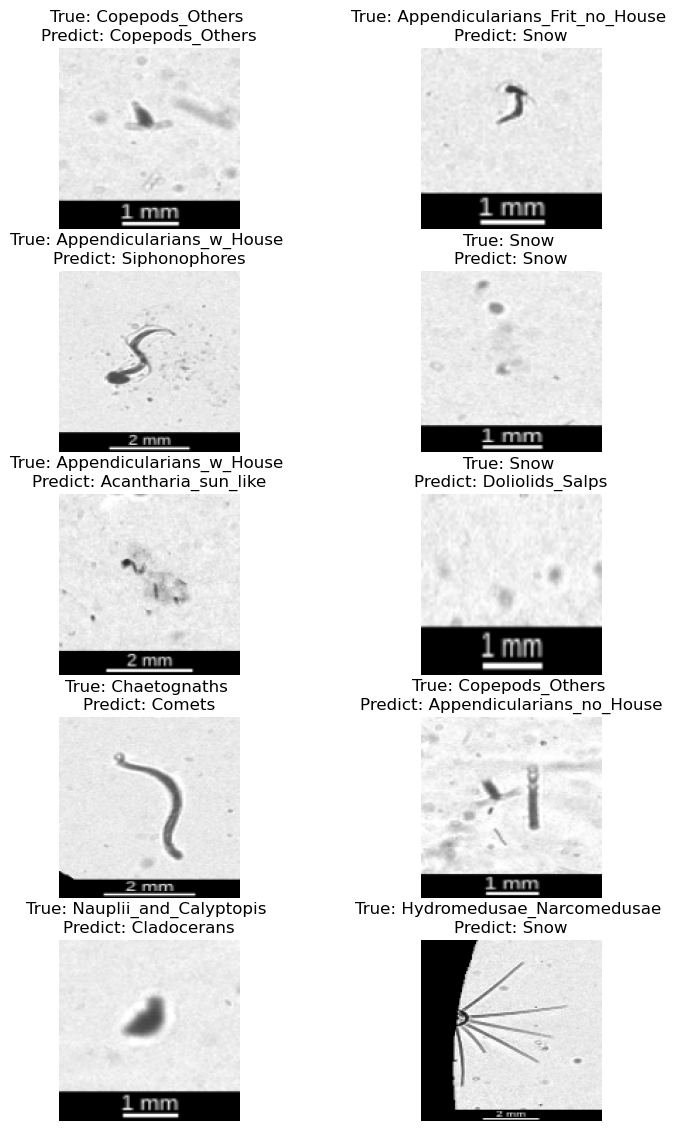

In [10]:
#grab 1 batch of predictions
imgs, true_labels = next(iter(val_ds_norm.take(1)))

#Perform forward inference (predictions) on a dataset
pred = smaller_model.predict(imgs)

# Converting the predictions into the single integer label index
pred_classes = np.argmax(pred, axis=1)

#TensorFlow dataset creates the labels in alphabetical order unless you specify otherwise
label_strings = sorted(os.listdir(set_15k))

#Use the label_strings as a lookup to turn integers to strings
string_predictions = np.vectorize(lambda x: label_strings[x])(pred_classes)

#Show a few of the images
fig, axes = plt.subplots(5,2, figsize=(7,14))
axes = axes.ravel()
for i in np.arange(0, 10):
    axes[i].imshow((255.0*imgs[i]).numpy().astype("uint8"))
    axes[i].set_title("True: %s \nPredict: %s" % (label_strings[np.argmax(true_labels[i])], string_predictions[i]), fontsize = 12)
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

#Confusion Matrix

* Check that predictions seem useful (strong signal across the entire diagonal

* Examine any notable pairs of commonly confused classes

[24 20 14 ... 11 21 29] 1329


2024-05-09 22:04:23.602701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/var/folders/x7/84xl7f8d74l7mmcr96v1dcs40000gn/T/ipykernel_4141/742968839.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.setp(plt.gca(), xticklabels=label_strings, yticklabels=label_strings, xticks=np.arange(0.5, 30.5), yticks=np.arange(0.5, 30.5),
/var/folders/x7/84xl7f8d74l7mmcr96v1dcs40000gn/T/ipykernel_4141/742968839.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.setp(plt.gca(), xticklabels=label_strings, yticklabels=label_strings, xticks=np.arange(0.5, 30.5), yticks=np.arange(0.5, 30.5),


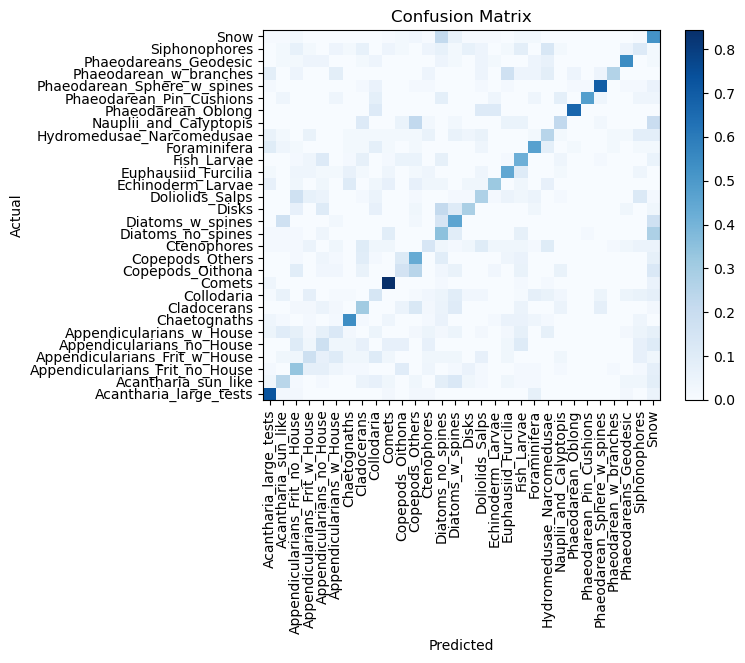

In [11]:
from sklearn.metrics import confusion_matrix

# pred = smaller_model.predict(train_ds_norm)
# pred_classes = np.argmax(pred, axis=1)

all_true_labels = []
all_pred_labels = []
for imgs, label in val_ds_norm:  # Ignore images
  all_true_labels.extend(label.numpy())
  all_pred_labels.extend(smaller_model.predict(imgs, verbose=0))
#   print(label.shape, imgs.shape)
print(np.argmax(all_true_labels, axis=1), len(np.argmax(all_true_labels, axis=1)))

conf_matrix = confusion_matrix(np.argmax(all_true_labels, axis=1), np.argmax(all_pred_labels, axis=1), normalize='true')
plt.pcolormesh(conf_matrix, cmap='Blues')
plt.setp(plt.gca(), xticklabels=label_strings, yticklabels=label_strings, xticks=np.arange(0.5, 30.5), yticks=np.arange(0.5, 30.5),
         xlabel='Predicted', ylabel='Actual', title='Confusion Matrix')
plt.xticks(rotation=90)
plt.colorbar()
plt.show()

In [21]:

print(np.argmax(pred, axis=1))
print(np.argmax(all_pred_labels, axis=1))

[16  2 28  0 20  0 21  4 25 29 13  8 17  1 26 25 12 14 12 26 29  3  2 29
 11  5  7  4 29  2 16 25]
[15  2 25 ... 16 22  5]


#Repeat the process with a much smaller model

* CNNs are not always right, or easy

* Next 4 cells are: shape model, compile/train model, examine predictions, check confusion matrix

In [12]:
#colab runtime ~1 sec
def make_tiny_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    print(inputs.shape)
    x = layers.Conv2D(16, 3, padding="same")(inputs)
    x = layers.MaxPooling2D(2, padding="same")(x)

    for size in [32]:
        #x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 3, padding="same")(x)
        # x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(2, padding="same")(x)
    x = layers.Flatten()(x)

    x = layers.Dense(64)(x)
    #x = layers.Dense(num_classes)(x)

    if num_classes == 2:
        units = 1
    else:
        units = num_classes
    # x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

tiny_model = make_tiny_model(input_shape=image_size+(3,), num_classes=30)
# keras.utils.plot_model(tiny_model, show_shapes=True) #This line doesn't work with TPUv2 environment :-/

(None, 128, 128, 3)


In [13]:
#Even this tiny model was taking a long time using CPU after I got some initial warnings about google colab credit usage
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("./savedModels/save_at_{epoch}.keras"), #to be changed to your private directory
]
tiny_model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
    metrics=['accuracy']
)
print('Done with model.compile, starting fitting (training)...')
tiny_history = tiny_model.fit(
    train_ds_norm,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds_norm,
 )  #model.fit has some default status output, including time estimate

Done with model.compile, starting fitting (training)...
Epoch 1/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.1297 - loss: 3.7274 - val_accuracy: 0.2483 - val_loss: 2.7971
Epoch 2/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.2744 - loss: 2.7332 - val_accuracy: 0.2829 - val_loss: 2.6448
Epoch 3/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.3415 - loss: 2.5255 - val_accuracy: 0.3521 - val_loss: 2.5227
Epoch 4/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.3984 - loss: 2.3684 - val_accuracy: 0.3717 - val_loss: 2.4792
Epoch 5/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.4316 - loss: 2.2603 - val_accuracy: 0.3762 - val_loss: 2.4283
Epoch 6/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.4755 - loss: 2.1493 - val_accuracy: 0.3958 - val_loss: 2.4350
Epoch 7/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5246 - loss: 2.0301 - val_accuracy: 0.3679 - val_loss: 2.5072
Epoch 8/20
289/289 ━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


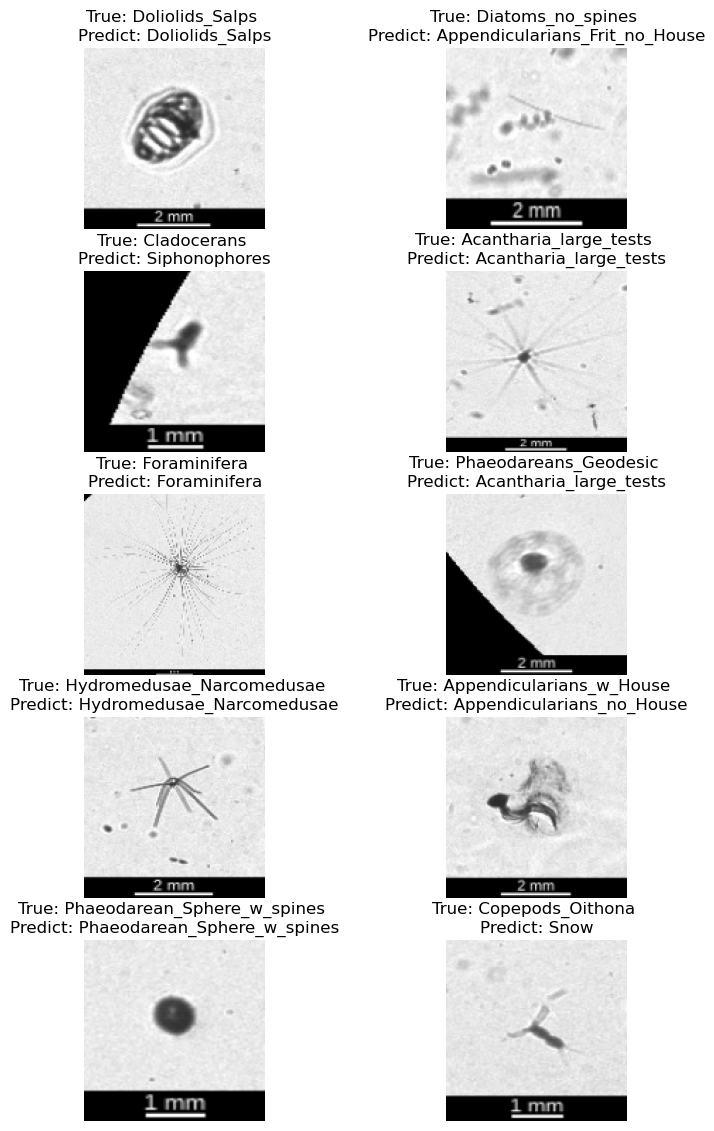

In [14]:
#tiny_history checking, showing almost all predictions are wrong
imgs, true_labels = next(iter(val_ds_norm.take(1)))

#Perform forward inference (predictions) on a dataset
pred = tiny_model.predict(imgs)

# Converting the predictions into the single integer label index
pred_classes = np.argmax(pred, axis=1)

#TensorFlow dataset creates the labels in alphabetical order unless you specify otherwise
label_strings = sorted(os.listdir(set_15k))

#Use the label_strings as a lookup to turn integers to strings
string_predictions = np.vectorize(lambda x: label_strings[x])(pred_classes)

fig, axes = plt.subplots(5,2, figsize=(7,14))
axes = axes.ravel()
for i in np.arange(0, 10):
    axes[i].imshow((imgs[i]*255.0).numpy().astype("uint8"))
    axes[i].set_title("True: %s \nPredict: %s" % (label_strings[np.argmax(true_labels[i])], string_predictions[i]), fontsize = 12)
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

2024-05-09 22:07:46.457568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/var/folders/x7/84xl7f8d74l7mmcr96v1dcs40000gn/T/ipykernel_4141/3442840637.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.setp(plt.gca(), xticklabels=label_strings, yticklabels=label_strings, xticks=np.arange(0.5, 30.5), yticks=np.arange(0.5, 30.5),
/var/folders/x7/84xl7f8d74l7mmcr96v1dcs40000gn/T/ipykernel_4141/3442840637.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.setp(plt.gca(), xticklabels=label_strings, yticklabels=label_strings, xticks=np.arange(0.5, 30.5), yticks=np.arange(0.5, 30.5),


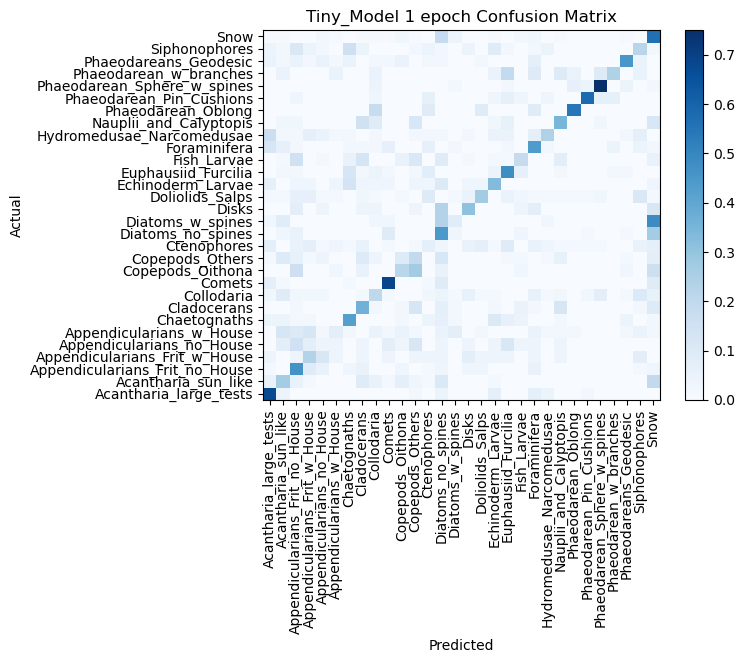

In [15]:
#displaying the confusion matrix for the poorly performing tiny model
from sklearn.metrics import confusion_matrix

all_true_labels = []
all_pred_labels = []
for imgs, label in val_ds_norm:  # Ignore images
  all_true_labels.extend(label.numpy())
  all_pred_labels.extend(tiny_model.predict(imgs, verbose=0))

conf_matrix = confusion_matrix(np.argmax(all_true_labels, axis=1),\
                               np.argmax(all_pred_labels, axis=1), normalize='true')
plt.pcolormesh(conf_matrix, cmap='Blues')
plt.setp(plt.gca(), xticklabels=label_strings, yticklabels=label_strings, xticks=np.arange(0.5, 30.5), yticks=np.arange(0.5, 30.5),
         xlabel='Predicted', ylabel='Actual', title='Tiny_Model 1 epoch Confusion Matrix')
plt.xticks(rotation=90)
plt.colorbar()
plt.show()

#Conclusion - Possible Investigations

* Remove Scalebars, Black regions on image. Previously addressed with gaussian noise

* Subdividing existing image classes, retrain.

* Implementing heirarchical categories, possible multi-stage algorithm

* Determine if the model is overfitting

* Implement Augmentation (will extend training time)

* Use the 30k dataset. Every image in the 15k dataset should also be in the 30k dataset

* Transfer learning (recommend purchasing Colab allocation or connecting with non-cloud GPU

#Extra: Analyze Image Size

*   Provided by Byungjun



In [16]:
import imageio.v3 as iio

def get_min_height_weight(folder_name_list):
    min_height = 100000
    min_width = 100000
    for folder_name in folder_name_list:
        print(folder_name)
        dataset_folder_path = dataset_path + folder_name + '/'
        dir_list = sorted(os.listdir(dataset_folder_path))
        for dir_idx, dir in enumerate(dir_list):
            print(dir)
            img_filename_list = glob.glob(dataset_folder_path + dir + '/*.png')
            for img_filename in img_filename_list:
                img = iio.imread(img_filename)
                height, width = img.shape
                if height < min_height:
                    min_height = height
                if width < min_width:
                    min_width = width


In [17]:
dataset_path = '/project/iarpa/byungjun/sioc209/plankton_data/'
folder_name_list = ['sioc_209_15k']
# folder_name_list = ['sioc_209_15k', 'sioc_209_30k']

min_height = 56
min_width = 65

for folder_name in folder_name_list:
    print(folder_name)
    dataset_folder_path = dataset_path + folder_name + '/'
    dir_list = sorted(os.listdir(dataset_folder_path))
    for dir_idx, dir in enumerate(dir_list):
        num_classes = len(folder_name_list)
        print(dir, end=' ')
        img_filename_list = glob.glob(dataset_folder_path + dir + '/*.png')
        for img_filename in img_filename_list:
            img = iio.imread(img_filename)
            # print(img.shape)
        print(len(img_filename_list))

sioc_209_15k


FileNotFoundError: [Errno 2] No such file or directory: '/project/iarpa/byungjun/sioc209/plankton_data/sioc_209_15k/'

#Extra: Confirm GPU is active

* This does not necessarily work with Tensor Processing Units

In [ ]:
import tensorflow as tf

# Configure TensorFlow session to use a specific GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)  # Optional: Enable memory growth
  logical_devices = tf.config.list_logical_devices('GPU')
  # Logical device will be assigned to the first physical device by default
  tf.config.set_visible_devices(logical_devices[0], 'GPU')

# Now, your Keras model will utilize the specified GPU

try:
  # Check for physical GPU devices
  physical_devices = tf.config.list_physical_devices('GPU')

  if physical_devices:
    # There are physical GPUs present
    print("Keras is configured to use GPUs.")

    # Check for memory usage on the first GPU (compatible approach)
    logical_devices = tf.config.list_logical_devices('GPU')
    if logical_devices:
      # Try using the recommended attribute for newer versions
      try:
        gpu_info = tf.config.experimental.get_logical_device_configuration(logical_devices[0])
        print(f"Memory allocated to the first GPU: {gpu_info['memory_limit']}")
      except (AttributeError, KeyError):  # Handle potential exceptions
        pass  # Don't print an error, info message already indicates GPU usage

      # Fallback for older versions (assuming 'memory_limit' is available)
      else:
        try:
          gpu_status = tf.config.status(logical_devices[0])
          memory_limit = gpu_status['memory_limit'] / 1024**2  # Convert to MB
          print(f"Memory allocated to the first GPU: {memory_limit} MB (estimated)")
        except (AttributeError, KeyError):
          pass  # Don't print an error, info message already indicates GPU usage

  else:
    print("Keras is not configured to use GPUs. (No GPUs detected)")

except Exception as e:
  # Handle potential errors (e.g., TensorFlow version incompatibility)
  print(f"Error checking GPU availability: {e}")

Keras is not configured to use GPUs. (No GPUs detected)


#Extra: Example code to do train/val split at the same time

In [ ]:
#Colab runtime ~15 sec

#confirm that the connection to Google Drive is correctly working
drive.mount('/content/drive', force_remount=True)
set_15k = '/content/drive/MyDrive/Colab Notebooks/SIOC-209 Data/plankton_data/sioc_209_15k'
print(f'Found {len(os.listdir(set_15k))} sub-directories to use for classification task')

image_size = (128, 128)
batch_size = 32
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    set_15k,
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    label_mode = 'categorical'
)

Mounted at /content/drive
Found 30 sub-directories to use for classification task
Found 15000 files belonging to 30 classes.
Using 12000 files for training.
Using 3000 files for validation.
